# Assignment 1 - Deep Learning with Keras

This assignment will test you on the following skills: implementing a convolutional neural network in Keras, utilising the Functional Model API, building custom layers and loss functions, and analysing a trained model.

The model you will be building is called a Variational Autoencoder (VAE), a special type of neural network that uses Bayesian Inference to generate synthetic data. As described in the lectures, a VAE compresses a sample input into a low dimensional space (a latent vector). A constraint is applied in the form of a modification to the loss function, which has the effect of forcing the latent vector to look like a standard normal distribution.

This notebook is divided into sections, which you should use to complete the following tasks:

1. Implement a custom layer that performs the "reparameterization trick" described in the lectures.
2. Use the functional model API in keras to create an encoder model and a decoder model, using the specifications provided. Combine these models into the full VAE architecture.
3. Train the model using the celeb_a dataset of celebrity faces.
4. Create plots that demonstrate the ability of the network to reconstruct images, and generate new images.

In addition to submitting your completed notebook, you should write a 1-page report that discusses the results of the model.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!mkdir /content/celeba

In [4]:
!unzip /content/drive/MyDrive/freelance/VAE/img_align_celeba.zip -d /content/celeba

Streaming output truncated to the last 5000 lines.
 extracting: /content/celeba/img_align_celeba/197600.jpg  
 extracting: /content/celeba/img_align_celeba/197601.jpg  
 extracting: /content/celeba/img_align_celeba/197602.jpg  
 extracting: /content/celeba/img_align_celeba/197603.jpg  
 extracting: /content/celeba/img_align_celeba/197604.jpg  
 extracting: /content/celeba/img_align_celeba/197605.jpg  
 extracting: /content/celeba/img_align_celeba/197606.jpg  
 extracting: /content/celeba/img_align_celeba/197607.jpg  
 extracting: /content/celeba/img_align_celeba/197608.jpg  
 extracting: /content/celeba/img_align_celeba/197609.jpg  
 extracting: /content/celeba/img_align_celeba/197610.jpg  
 extracting: /content/celeba/img_align_celeba/197611.jpg  
 extracting: /content/celeba/img_align_celeba/197612.jpg  
 extracting: /content/celeba/img_align_celeba/197613.jpg  
 extracting: /content/celeba/img_align_celeba/197614.jpg  
 extracting: /content/celeba/img_align_celeba/197615.jpg  
 extr

In [5]:
import pathlib
import tensorflow as tf

import tensorflow_datasets as tfds

print("Tensorflow Version: ", tf.__version__)

data_dir = pathlib.Path('/content/celeba/img_align_celeba')
list_ds = tf.data.Dataset.list_files(str(data_dir/'*.jpg'), shuffle=False)

def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [128, 128])

def process_path(file_path):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  img = tf.cast(img, 'float32')/255.
  return img, img

proc_ds = list_ds.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = proc_ds.take(20000).cache().batch(64, drop_remainder=True)
valid_ds = proc_ds.take(10000).cache().batch(64, drop_remainder=True)
test_ds = proc_ds.take(10000).cache().batch(64, drop_remainder=True)

x_test = None

for image, label in tfds.as_numpy(test_ds):
  print(type(image), type(label), label, len(label))
  x_test = image
  print('------')

Streaming output truncated to the last 5000 lines.
   ...
   [0.6261448  0.49566075 0.38790116]
   [0.5558024  0.42413858 0.32094726]
   [0.48360908 0.35027573 0.25223652]]

  [[0.13335846 0.18672857 0.23847489]
   [0.6442318  0.6843973  0.7461926 ]
   [0.8197043  0.8473391  0.9178354 ]
   ...
   [0.6999583  0.5783897  0.46466926]
   [0.6443486  0.5179087  0.407734  ]
   [0.6617841  0.5284508  0.42896345]]

  [[0.15438113 0.20775123 0.25949755]
   [0.69298404 0.7331495  0.7949449 ]
   [0.795527   0.8231618  0.8936581 ]
   ...
   [0.5819257  0.46035707 0.3466316 ]
   [0.5547433  0.42830333 0.31782538]
   [0.51979166 0.38645834 0.280576  ]]]


 [[[0.3111826  0.65235907 0.8602022 ]
   [0.3111826  0.65235907 0.8602022 ]
   [0.3111826  0.65235907 0.8602022 ]
   ...
   [0.3295037  0.6785233  0.9032169 ]
   [0.33666968 0.6774816  0.90226406]
   [0.3645898  0.686539   0.9112745 ]]

  [[0.31786153 0.659038   0.86688113]
   [0.31786153 0.659038   0.86688113]
   [0.31786153 0.659038   0.86688113]

# Task 1 - Reparameterisation layer

In [6]:
### Create a class called latent_sampling, which subclasses layers.Layer.
### The class should perform the reparameterisation trick in its .call()
### method.
### Reparameterization Trick: z = mean + epsilon * exp(ln(variance) * 0.5)
### epsilon = N(0,1), a unit normal with same dims as mean and variance

# Include the follow two lines in your .call method:
# self.add_loss(-0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar)))
# self.add_metric(-0.5 * tf.reduce_sum(1 + logvar - tf.square(mean) - tf.exp(logvar)), name='kl_loss')

import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

class latent_sampling(layers.Layer):
    def __init__(self):
        super(latent_sampling, self).__init__()
        self._name = "z"

    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.random.normal(tf.shape(z_mean))
        z = z_mean + epsilon * tf.exp(z_log_var * 0.5)
        self.add_loss(-0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)))
        self.add_metric(-0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)), name='kl_loss')
        return z


# Task 2 - Model Definitions

In [ ]:
### Create the encoder model, using the functional API and the architecture
### detailed below. Use tf.keras.models.Model to initialise the model.

# Model: "encoder"
# ____________________________________________________________________________________________________
#  Layer (type)            Output Shape           Activation  kernel_size  padding  Input
# ====================================================================================================
#  enc_input (InputLayer)  [(None, 128, 128, 3)]  None
#  enc_conv_1 (Conv2D)     (None, 64, 64, 32)     ReLU        (3,3)        'same'   enc_input
#  enc_conv_2 (Conv2D)     (None, 32, 32, 64)     ReLU        (3,3)        'same'   enc_conv_1
#  enc_conv_3 (Conv2D)     (None, 16, 16, 64)     ReLU        (3,3)        'same'   enc_conv_2    
#  enc_conv_4 (Conv2D)     (None, 8, 8, 64)       ReLU        (3,3)        'same'   enc_conv_3    
#  enc_flat (Flatten)      (None, 4096)           None        None         None     enc_conv_4
#  z_mean (Dense)          (None, 200)            None        None         None     enc_flat                        
#  z_log_var (Dense)       (None, 200)            None        None         None     enc_flat
#  z (latent_sampling)     (None, 200)            None        None         None     (z_mean, z_log_var)


Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 enc_conv_1 (Conv2D)            (None, 64, 64, 32)   896         ['enc_input[0][0]']              
                                                                                                  
 enc_conv_2 (Conv2D)            (None, 32, 32, 64)   18496       ['enc_conv_1[0][0]']             
                                                                                                  
 enc_conv_3 (Conv2D)            (None, 16, 16, 64)   36928       ['enc_conv_2[0][0]']       

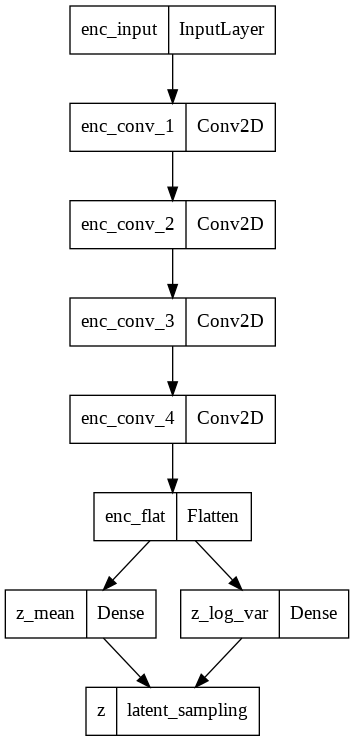

In [7]:
# Define the input layer
enc_input = tf.keras.Input(shape=(128, 128, 3),name="enc_input")

# Define the encoder layers
enc_conv_1 = tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3),strides=2,activation='relu', padding='same',name="enc_conv_1")(enc_input)

enc_conv_2 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=2, activation='relu', padding='same',name="enc_conv_2")(enc_conv_1)

enc_conv_3 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=2, activation='relu', padding='same',name="enc_conv_3")(enc_conv_2)

enc_conv_4 = tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3),strides=2, activation='relu', padding='same',name="enc_conv_4")(enc_conv_3)

enc_flat = tf.keras.layers.Flatten(name="enc_flat")(enc_conv_4)

# Define the output layers
z_mean = tf.keras.layers.Dense(200,name="z_mean")(enc_flat)
z_log_var = tf.keras.layers.Dense(200,name="z_log_var")(enc_flat)

# Define the latent sampling layer
z = latent_sampling()([z_mean, z_log_var])

# Initialize the encoder model
encoder = tf.keras.models.Model(inputs=enc_input, outputs=z, name="encoder")
encoder.summary()
tf.keras.utils.plot_model(encoder)

In [ ]:
### Create the decoder model, using the functional API and the architecture
### detailed below. Use tf.keras.models.Model to initialise the model.

# Model: "decoder"
# ____________________________________________________________________________________________________
#  Layer (type)                   Output Shape           Activation  kernel_size  padding  Input
# ====================================================================================================
#  dec_input (InputLayer)         [(None, 200)]          None
#  dec_dense (Dense)              (None, 4096)           ReLU        None         None     dec_input
#  dec_reshape (Reshape)          (None, 8, 8, 64)       None        None         None     dec_dense
#  dec_conv_1 (Conv2DTranspose)   (None, 8, 8, 64)       ReLU        (3,3)        'same'   dec_reshape
#  dec_conv_2 (Conv2DTranspose)   (None, 16, 16, 64)     ReLU        (3,3)        'same'   dec_conv_1
#  dec_conv_3 (Conv2DTranspose)   (None, 32, 32, 64)     ReLU        (3,3)        'same'   dec_conv_2    
#  dec_conv_4 (Conv2DTranspose)   (None, 64, 64, 32)     ReLU        (3,3)        'same'   dec_conv_3    
#  dec_output (Conv2DTranspose)   (None, 128, 128, 3)    ReLU        (3,3)        'same'   dec_conv_4


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dec_input (InputLayer)      [(None, 200)]             0         
                                                                 
 dec_dense (Dense)           (None, 4096)              823296    
                                                                 
 dec_reshape (Reshape)       (None, 8, 8, 64)          0         
                                                                 
 dec_conv_1 (Conv2DTranspose  (None, 8, 8, 64)         36928     
 )                                                               
                                                                 
 dec_conv_2 (Conv2DTranspose  (None, 16, 16, 64)       36928     
 )                                                               
                                                                 
 dec_conv_3 (Conv2DTranspose  (None, 32, 32, 64)       3692

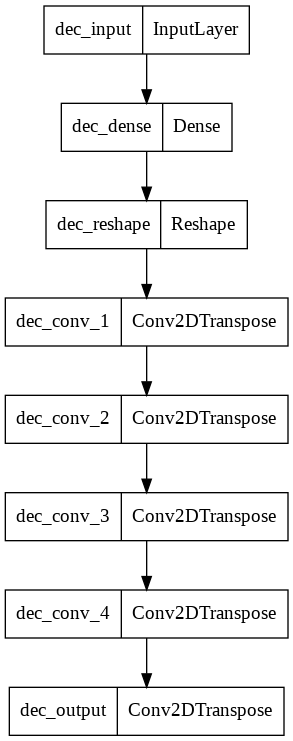

In [8]:
# Define the input layer
dec_input = tf.keras.Input(shape=(200),name="dec_input")

dec_dense = tf.keras.layers.Dense(4096,activation='relu',name="dec_dense")(dec_input)
dec_reshape = tf.keras.layers.Reshape((8,8,64),name="dec_reshape")(dec_dense)

# Define the encoder layers
dec_conv_1 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3),strides=1,activation='relu', padding='same',name="dec_conv_1")(dec_reshape)

dec_conv_2 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3),strides=2, activation='relu', padding='same',name="dec_conv_2")(dec_conv_1)

dec_conv_3 = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3,3),strides=2, activation='relu', padding='same',name="dec_conv_3")(dec_conv_2)

dec_conv_4 = tf.keras.layers.Conv2DTranspose(filters=32, kernel_size=(3,3),strides=2, activation='relu', padding='same',name="dec_conv_4")(dec_conv_3)

dec_output = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3,3),strides=2, activation='relu', padding='same',name="dec_output")(dec_conv_4)

# Initialize the encoder model
decoder = tf.keras.models.Model(inputs=dec_input, outputs=dec_output, name="decoder")
decoder.summary()
tf.keras.utils.plot_model(decoder)

In [ ]:
### Create the VAE model, again using tf.keras.models.Model, with the function
### API to combine the feed the outputs of the encoder into the inputs of the
### decoder.

In [9]:
vae = tf.keras.models.Model(inputs=encoder.inputs, outputs=decoder(encoder.outputs),name="Full_VAE")

# Task 3 - Train the model

In [10]:
# Provided here are the loss functions for the VAE model.
def recon_loss(y_true, y_pred):
    recon = tf.reduce_sum(tf.square(y_true-y_pred), axis=(1,2,3))
    return tf.reduce_mean(recon)

In [ ]:
### Compile the VAE model, choosing an appropriate optimizer and learning rate,
### the total_loss function as the model loss, and any appropriate metrics.

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
vae.compile(optimizer=optimizer, loss=recon_loss)

In [12]:
vae.summary()

Model: "Full_VAE"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 enc_input (InputLayer)         [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 enc_conv_1 (Conv2D)            (None, 64, 64, 32)   896         ['enc_input[0][0]']              
                                                                                                  
 enc_conv_2 (Conv2D)            (None, 32, 32, 64)   18496       ['enc_conv_1[0][0]']             
                                                                                                  
 enc_conv_3 (Conv2D)            (None, 16, 16, 64)   36928       ['enc_conv_2[0][0]']      

In [ ]:
### Train the model using the train dataset for an appropriate number of epochs.
### Store the losses and metrics in the history dictionary.

In [13]:
history = vae.fit(train_ds, validation_data=valid_ds, epochs=30)

Epoch 1/30
312/312 [==============================] - 46s 118ms/step - loss: 4122.8179 - kl_loss: 305.6445 - val_loss: 2799.2524 - val_kl_loss: 386.4652
Epoch 2/30
312/312 [==============================] - 35s 111ms/step - loss: 2746.2766 - kl_loss: 433.8121 - val_loss: 2673.6255 - val_kl_loss: 448.9779
Epoch 3/30
312/312 [==============================] - 34s 108ms/step - loss: 2547.9873 - kl_loss: 443.0597 - val_loss: 2454.3777 - val_kl_loss: 424.1394
Epoch 4/30
312/312 [==============================] - 33s 106ms/step - loss: 2405.2449 - kl_loss: 435.9026 - val_loss: 2369.0059 - val_kl_loss: 421.4276
Epoch 5/30
312/312 [==============================] - 33s 105ms/step - loss: 2324.1772 - kl_loss: 453.6167 - val_loss: 2287.0244 - val_kl_loss: 472.1993
Epoch 6/30
312/312 [==============================] - 33s 104ms/step - loss: 2268.5811 - kl_loss: 465.8806 - val_loss: 2249.3064 - val_kl_loss: 453.9555
Epoch 7/30
312/312 [==============================] - 33s 105ms/step - loss: 2235.

In [14]:
vae.save("/content/drive/MyDrive/freelance/VAE/full_vae.h5")

# Task 4 - Analyse the Model

In [ ]:
### Plot the losses and metrics. Comment on the figures in your report, with
### regard to how the training has proceeded.

In [15]:
print(history.history.keys())

dict_keys(['loss', 'kl_loss', 'val_loss', 'val_kl_loss'])


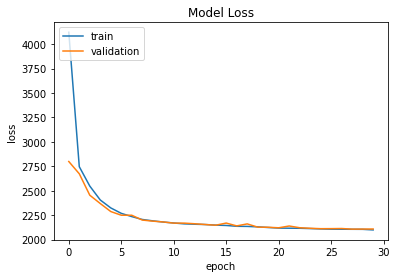

In [16]:
import matplotlib.pyplot as plt
# summarize history for loss and val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

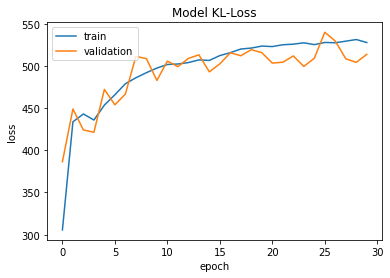

In [17]:
# summarize history for kl_loss and val_kl_loss
plt.plot(history.history['kl_loss'])
plt.plot(history.history['val_kl_loss'])
plt.title('Model KL-Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
### Using the test dataset, create a plot that shows the reconstruction quality
### of the training model. Comment on the results in your report.

In [18]:
test_pred_y = vae.predict(x_test)

2/2 [==============================] - 0s 8ms/step


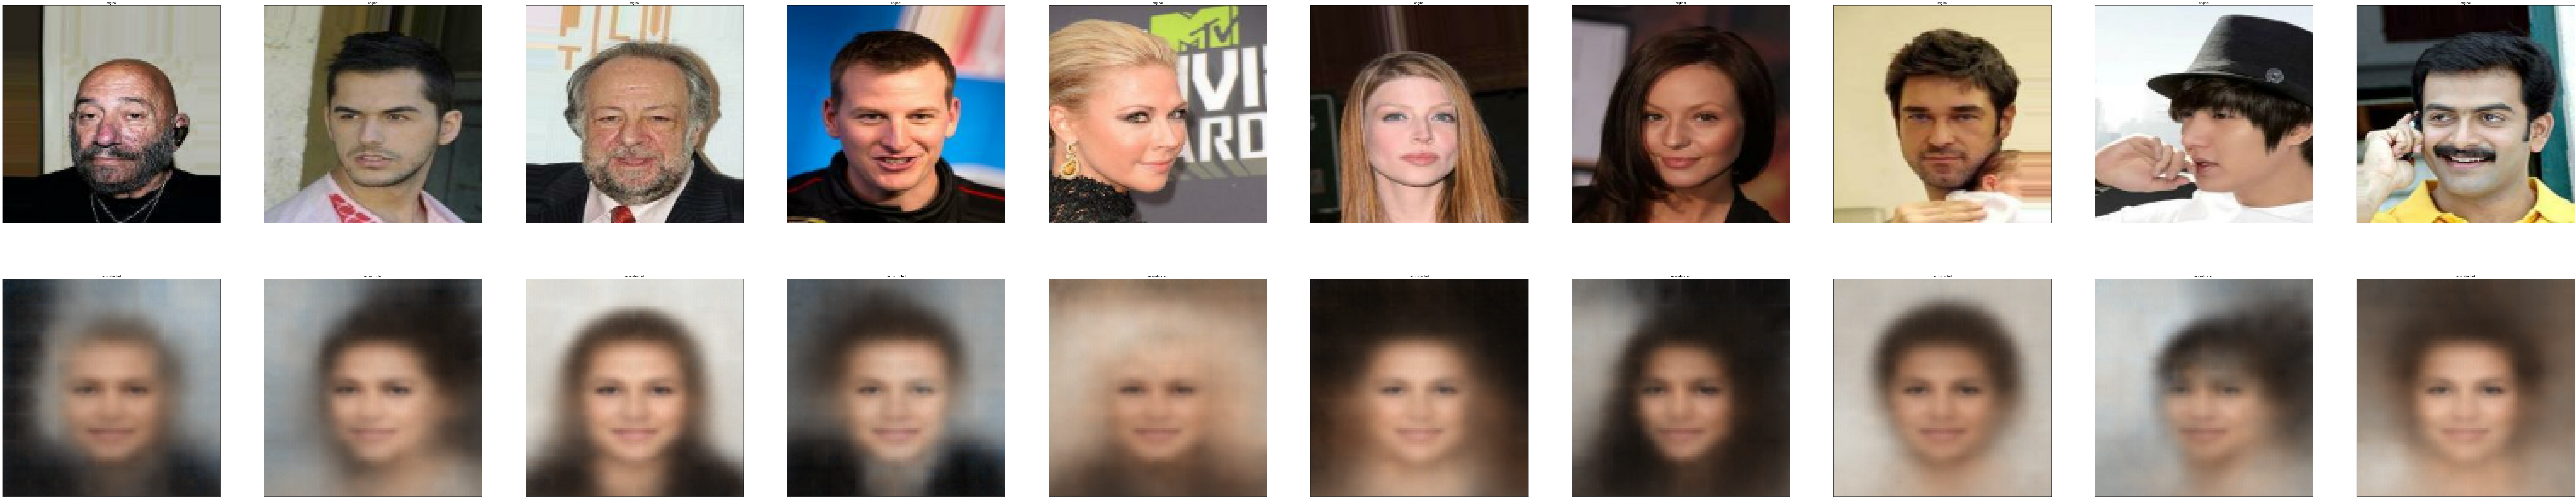

In [19]:
n = 10
plt.figure(figsize=(200, 40))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(test_pred_y[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
### Demonstrate the generative properties of the VAE by drawing randomly sampled
### latent vectors from a unit Guassian and passing them to the train decoder.
### Plot the results and comment on them in your report.

In [20]:
import tensorflow_probability as tfp

tfd = tfp.distributions
tfpl = tfp.layers
tfb = tfp.bijectors

def get_prior(num_modes, latent_dim):
    prior = tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=[1 / num_modes,] * num_modes),
        components_distribution=tfd.MultivariateNormalDiag(
            loc=tf.Variable(tf.random.normal(shape=[num_modes, latent_dim])),
            scale_diag=tfp.util.TransformedVariable(tf.Variable(tf.ones(shape=[num_modes, latent_dim])), bijector=tfb.Softplus())
        )
    )
    return prior

In [21]:
prior = get_prior(num_modes=2, latent_dim=200)
prior

<tfp.distributions.MixtureSameFamily 'MixtureSameFamily' batch_shape=[] event_shape=[200] dtype=float32>

In [22]:
def generate_images(prior, decoder, n_samples):
    """
    The function takes the prior distribution, decoder and number of samples as inputs, which
    should be used to generate the images.
    The function should then return the batch of generated images.
    """
    z = prior.sample(n_samples).numpy()
    return decoder(z)

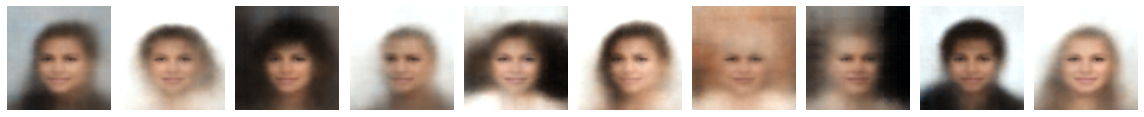

In [23]:
n_samples = 10
sampled_images = generate_images(prior, decoder, n_samples)

f, axs = plt.subplots(1, n_samples, figsize=(16, 6))

for j in range(n_samples):
    axs[j].imshow(sampled_images[j])
    axs[j].axis('off')
    
plt.tight_layout();